In [1]:
from imports import *
import traces_rdf
import ChannelShape
%matplotlib inline

supersim = os.environ["CDMS_SUPERSIM"]
# Pull in Warren's detector-channel drawing utility from SuperSim
sys.path.append(os.path.join(supersim,"CDMSscripts","validation"))
import detectorLayout

Welcome to JupyROOT 6.24/06


In [2]:
datadir='data/FastDMC/Compare'
source=f'{datadir}/Ge71-iZIP5_00240320_0000.root'
fastdmc=f'{datadir}/Ge71-FastDMC_00240320_0000.root'
fulldmc=f'{datadir}/Ge71-FullDMC_51240320_*.root'     # Does this work with RDataFrame?

In [3]:
channels = detectorLayout.loadGeometry(source)

Extracting geometry data...


In [4]:
# Data and plots of initial decay products
branches = ["EventNum","TrkStep","Parent","KE","X1","Y1","Z1","Edep","PName"]
decays = ROOT.RDataFrame(f"G4SimDir/mczip0", source, branches)\
    .Filter("Parent==1 & int(TrkStep)%100000==1").AsNumpy(branches)
traces_rdf.convertRDFBranches(decays)

hits = ROOT.RDataFrame(f"G4SimDir/mczip0", source, branches).AsNumpy(branches)
traces_rdf.convertRDFBranches(hits)

{'EventNum': ndarray([  0.,   0.,   0., ..., 999., 999., 999.]),
 'TrkStep': ndarray([300001., 200001., 400001., ..., 700001., 800001., 900001.]),
 'Parent': ndarray([1., 1., 1., ..., 1., 1., 1.]),
 'KE': ndarray([1.75031307e+01, 3.67350008e+01, 1.06782590e+03, ...,
          9.87321648e+02, 9.20898035e+03, 3.74115189e-01]),
 'X1': ndarray([0.02011401, 0.02011401, 0.02011401, ..., 0.03123298, 0.03123298,
          0.03123298]),
 'Y1': ndarray([0.0249728 , 0.0249728 , 0.0249728 , ..., 0.00720867, 0.00720867,
          0.00720867]),
 'Z1': ndarray([0.01566822, 0.01566822, 0.01566822, ..., 0.02135887, 0.02135887,
          0.02135887]),
 'Edep': ndarray([1.75031307e+01, 3.67350008e+01, 1.06782590e+03, ...,
          9.87321648e+02, 9.20898035e+03, 3.74115189e-01]),
 'PName': array(['e-', 'e-', 'e-', ..., 'e-', 'gamma', 'Ga71'], dtype='<U5')}

In [5]:
gammaKE  = decays['KE'][decays['PName']=="gamma"]/1e3
elecKE   = decays['KE'][decays['PName']=="e-"]/1e3
recoilKE = decays['KE'][decays['PName']=="Ga71"]/1e3
particles = ['gamma','e-','Ga71 NR']

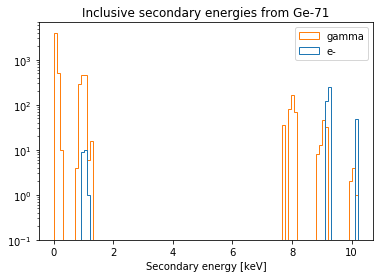

In [6]:
fig,axes = plt.subplots()
axes.hist([gammaKE,elecKE],bins=100,histtype='step',fill=False,log=True)
axes.legend(particles,loc="upper right",ncol=1)
axes.set_xlabel("Secondary energy [keV]")
axes.set_title("Inclusive secondary energies from Ge-71")
fig.savefig("Ge71-decay_KE.png")

In [7]:
# Total energy produced in Ge-71 decays

# https://stackoverflow.com/questions/36643216/summing-data-from-array-based-on-other-array-in-numpy
eventID,index,nsec = np.unique(decays["EventNum"],return_counts=True,return_inverse=True)
sumEsec = np.bincount(index,decays["KE"].ravel())              # Array of sums in same order as eventID
eventEsec = {i:sumEsec[itr] for itr,i in enumerate(eventID)}   # Dictionary to use eventID for lookup

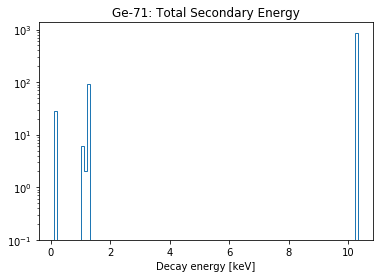

In [8]:
fig,axes = plt.subplots()
axes.hist(sumEsec/1e3,bins=100,histtype='step',fill=False,log=True)
axes.set_xlabel("Decay energy [keV]")
axes.set_title("Ge-71: Total Secondary Energy")
fig.savefig("Ge71-decay_Etot.png")

In [9]:
# Total energy deposited in detector from Ge-71 decays

# https://stackoverflow.com/questions/36643216/summing-data-from-array-based-on-other-array-in-numpy
eventID,index,nhit = np.unique(decays["EventNum"],return_counts=True,return_inverse=True)
sumEdep = np.bincount(index,decays["Edep"].ravel())            # Array of sums in same order as eventID
eventEdep = {i:sumEdep[itr] for itr,i in enumerate(eventID)}   # Dictionary to use eventID for lookup
eventNhit = {i:nhit[itr] for itr,i in enumerate(eventID)}   # Dictionary to use eventID for lookup

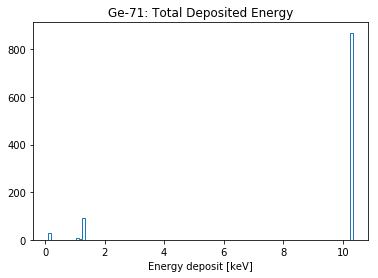

In [39]:
fig,axes = plt.subplots()
axes.hist(sumEdep/1e3,bins=100,histtype='step',fill=False,log=False)
axes.set_xlabel("Energy deposit [keV]")
axes.set_title("Ge-71: Total Deposited Energy")
fig.savefig("Ge71-decay_Edep.png")

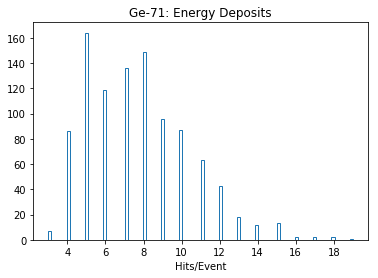

In [11]:
# Number of hits per event (couted above in mczip0, should match mcevent.HitsPerEvent)

fig,axes = plt.subplots()
axes.hist(eventNhit.values(),bins=100,histtype='step',fill=False,log=False)
axes.set_xlabel("Hits/Event")
axes.set_title("Ge-71: Energy Deposits")
fig.savefig("Ge71-decay_Nhit.png")

In [32]:
# Total energy collection from FastDMC

branches = ["EventNum","PhononE","ChargeQ"]
fasttot = ROOT.RDataFrame(f"G4SimDir/g4dmcEvent", fastdmc, branches).AsNumpy(branches)
traces_rdf.convertRDFBranches(fasttot)

fastPhononE = np.array([sum(fasttot["PhononE"][i]) for i in range(0,len(fasttot["PhononE"]))])
fastChargeQ = np.array([(abs(fasttot["ChargeQ"][i][0]+fasttot["ChargeQ"][i][1])+abs(fasttot["ChargeQ"][i][2]+fasttot["ChargeQ"][i][3]))/2 for i in range(0,len(fasttot["EventNum"]))])

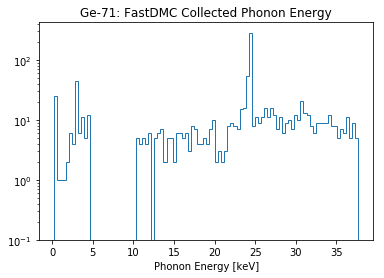

In [22]:
fig,axes = plt.subplots()
axes.hist(fastPhononE/1e3,bins=100,histtype='step',fill=False,log=True)
axes.set_xlabel("Phonon Energy [keV]")
axes.set_title("Ge-71: FastDMC Collected Phonon Energy")
fig.savefig("Ge71-decay_fastPhononE.png")

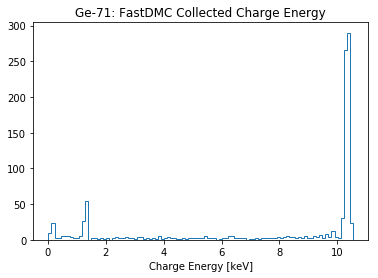

In [38]:
fig,axes = plt.subplots()
axes.hist(fastChargeQ*2.96/1e3,bins=100,histtype='step',fill=False,log=False)
axes.set_xlabel("Charge Energy [keV]")
axes.set_title("Ge-71: FastDMC Collected Charge Energy")
fig.savefig("Ge71-decay_fastChargeQ.png")

In [35]:
# Total energy collection from full GDMC

branches = ["EventNum","PhononE","ChargeQ"]
dmctot = ROOT.RDataFrame(f"G4SimDir/g4dmcEvent", fulldmc, branches).AsNumpy(branches)
traces_rdf.convertRDFBranches(dmctot)

dmcPhononE = np.array([sum(dmctot["PhononE"][i]) for i in range(0,len(dmctot["EventNum"]))])
dmcChargeQ = np.array([(abs(dmctot["ChargeQ"][i][0]+dmctot["ChargeQ"][i][1])+abs(dmctot["ChargeQ"][i][2]+dmctot["ChargeQ"][i][3]))/2 for i in range(0,len(dmctot["EventNum"]))])

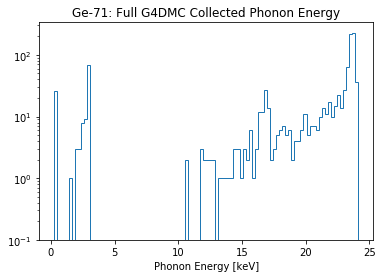

In [25]:
fig,axes = plt.subplots()
axes.hist(dmcPhononE/1e3,bins=100,histtype='step',fill=False,log=True)
axes.set_xlabel("Phonon Energy [keV]")
axes.set_title("Ge-71: Full G4DMC Collected Phonon Energy")
fig.savefig("Ge71-decay_dmcPhononE.png")

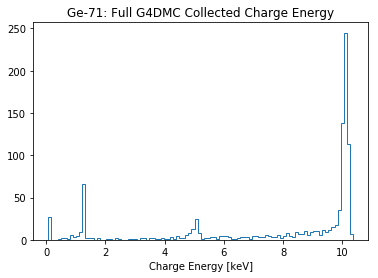

In [37]:
fig,axes = plt.subplots()
axes.hist(dmcChargeQ*2.96/1e3,bins=100,histtype='step',fill=False,log=False)
axes.set_xlabel("Charge Energy [keV]")
axes.set_title("Ge-71: Full G4DMC Collected Charge Energy")
fig.savefig("Ge71-decay_dmcChargeQ.png")